In [1]:
import warnings
warnings.filterwarnings("ignore")
# ipykernel warnings should get fixed w/ new release:
# https://github.com/ipython/ipykernel/pull/617

# Spatial Feature Engineering

In machine learning and data science, we are often equipped with *tons* of data. Indeed, given the constellation of packages to query data services, free and open source data sets, and the rapid and persistent collection of geographical data, there is simply too much data to even represent coherently in a single, tidy fashion. However, we often need to be able to construct useful *features* from this rich and deep sea of data. 

Where data is available, but not yet directly *usable*, *feature engineering* helps to construct representations or transformations of the original data that are more useful for modeling a given phenomenon of interest. In traditional machine learning, feature engineering involves applying additional *domain knowledge* to raw information in order to structure it in a manner that is meaningful for a model. Often, this involves some sort of *transformation* of the original dataset, which is a well-studied concept in both classical statistics and remains so in machine learning methods. While *feature engineering* always relies on this implicit domain knowledge, it is an extremely important part of adapting general-purpose algorithms to unique or distinctive problems facing the every-day data scientist. 

Geography is one of the most high-quality, ubiquitous ways to introduce *domain knowledge* into a problem: everything has a position in both *space* and *time*. And, while things that happen near to one another *in time* do not necessarily have a fundamental relationship, things that are *near* one another are often related. Thus, space is the ultimate *linkage key*, allowing us to connect different datasets together in order to improve our models and our predictions. This means that, even for *aspatial*, "non-geographic" data, you can use *spatial feature engineering* to create useful, highly-relevant features for your analysis. 

At its core, *spatial feature engineering* is the process of developing additional information from raw data using *geographic knowledge*. This distilling of information can occur *between* datasets, where geography is used to link information in separate datasets together; or *within* datasets, where geography can be used to augment the information available for one sample by borrowing from nearby ones. This chapter is structured following that distinction: for cases where geography connects *different* datasets, we adopt the term "Map Matching", often used in industry; while we use the mirroring concept of "Map Synthesis" describing the use of geographical structure to derive new features from a given dataset. Technically speaking, some of the methods we review are similar across these two cases, or even the same; however they can be applied in the context of "matching" or "synthesis", and we consider those conceptually different, hence their inclusion in both sections. Throughout the chapter, we use the AirBnB nightly rental prices in San Diego, as well as auxiliary datasets such as elevation or Census demographics.

In [2]:
import geopandas, pandas, libpysal.weights as weights, contextily
import matplotlib.pyplot as plt
import cenpy
import numpy
import osmnx
import seaborn
import rasterio
from rasterio.plot import show as rioshow

In [3]:
osmnx.config(
    overpass_settings='[out:json][timeout:90][date:"2021-10-07T00:00:00Z"]'
)

Throughout this chapter, we will use the same dataset to which we want to append more information or augment, and we will do so through leveraging geography. For the illustration, we will use the set of [AirBnB properties](../data/airbnb/regression_cleaning) we have used in the [previous chapter](11_regression). Let's read it:

In [4]:
airbnbs = geopandas.read_file('../data/airbnb/regression_db.geojson')

## What is spatial feature engineering? 

At its core, *spatial feature engineering* is the process of developing additional information from raw data using *geographic knowledge*. This synthesis could occur *between* datasets, where geography is used to link samples in separate datasets together; or *within* datasets, where geography can be used to borrow information from nearby samples. Building linkages *between* datasets is often called "Map Matching", while we use the term "Map Synthesis" to describe the use of geographical structure to derive new features from existing data. We will cover both kinds of feature engineering.

To help us discuss this, a vocabulary is helpful. We will cover a few different kinds of features in this chapter, both of which can be constructed in either Map Synthesis or Map Matching operations: 
- A *spatial summary feature* measures the attributes of observations that have some pre-specified spatial relationship with our target observations. This includes 
    - taking the average or median value of features within a neighborhood of each target observation. 
    - the *spatial lag*, used in previous chapters of this book (e.g., Chapters [3](03_spatial_data), [6](06_spatial_autocorrelation), and [11](11_regression), is a kind of spatial summary feature, since it reflects the average value of the data in the neighborhood around each point. 
    - Other kinds of spatial summary features might include the count of observations within a given distance or the standard deviation of ten nearest observations. 
    - Summary features generally include *interpolated features* which involve a transfer of information from one spatial support to another, such as when the target locations are not the same as the locations in our ancillary data. Interpolated features become significantly more complex as well when the data is *areal*, as will be discussed later in this chapter.
- A *proximity feature* measures the distance from a target observation to some other observation or position in the map. This might be done in a map matching context, as we did before with the distance to Balboa Park in [Chapter 11](11_regression), or it might be done in a map synthesis context by measuring the distance to the nearest other observation. 

## Feature Engineering Using Map Matching

Space is the ultimate linkage key; map matching is all about exploiting this asset. Geographic information is collected at different scales, aggregated using bespoke geographic delineations, and ultimately stored in different datasets. Modeling and machine learning usually require the use of data aligned and coherently structured; to bring disparate geo-datasets together, the data scientist needs to be able to transfer information expressed for one geography into another. This is where map matching comes to the rescue. By using geographical location, we can connect datasets that have no common key or that are otherwise completely unrelated. This is a "magic trick" that we can pull off because of location that would be much harder, or impossible, with data lacking spatial information.

The details, and difficulty, of this transfer of information from one geography to another one depend on the nature of the "source" and "target", and on the precision with which we want to perform such transfer. In this context, there is always an inevitable trade-off between precision and sophistication: more precise transfer is usually possible at the expense of more advanced and involved techniques. Their additional cost in applying them, both in terms of cognitive load on the data scientist's part or in terms of computation, must be weighted in on an individual basis: sometimes we need the best possible estimates, at all costs; sometimes "good enough" is, well, good enough. 

In this section, we cover a few cases that we consider represent the most common and widely used approaches. We begin with situations where we have two point datasets and all we need to calculate are descriptive statistics of one dataset to the observations in the other. We switch the type of data and consider how to attach information from a continuous grid, stored in a raster file, to a set of points. Then we show the equivalent case for "moving" information for a polygon geography to a point dataset. These are all cases that, in their simplest form, involve mostly traditional GIS operations (e.g., buffer construction, spatial joins) and little in the way of statistical modeling. As an example of a case that is more involved, we cover the transfer of information from a set of points to another set of points in different locations, and of a polygon geography to another different polygon geography. For these final cases, but also as more generally, we try to include examples that capture the essence of the method, but keep the technique as simple as possible. For almost any of these cases we cover, the reader can find more sophisticated techniques that usually yield more accurate estimates. Where possible, we try to signpost these.

### Counting *nearby* features

A first, conceptually straightforward, approach is to augment our dataset by counting how many points of a different dataset are in the vicinity of each observation. For example, we might want to know how many bars and restaurants each AirBnB has within a given radius. This count can then become an additional  feature of our dataset, stored in a new column of `airbnbs`.

To obtain information on the location of restaurants and bars, we can download it from OpenStreetMap directly using `osmnx`. We first query all the points of interest (POIs) within the area our points cover, and then filter out everything except restaurants and bars. For that, we require  a polygon that covers all our `airbnbs` points. From [Chapter 8](08_point_pattern_analysis), we can recall that there are a few different hulls that can be used. We'll use the Convex Hull here, which is the smallest convex polygon that covers all of the points in the set. 

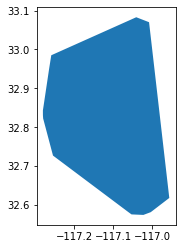

In [5]:
airbnbs_ch = airbnbs.unary_union.convex_hull
geopandas.GeoSeries([airbnbs_ch]).plot();

Using this polygon, we can use the `osmnx` package to fetch points of interest (POIs) from OpenStreetMap. We can make our request more manageable by only requesting points of interest that fall within specific categories. Below, we'll request POIs within San Diego that are "restaurants" or "bars," according to their metadata stored in OpenStreetMap. Once returned, we only keep a few columns to keep the table small and tidy:

In [6]:
%%time
pois = osmnx.geometries_from_polygon(
    airbnbs_ch, tags={"amenity": ['restaurant', 'bar']}
)[["unique_id", "osmid", "amenity", "cuisine", "name", "geometry"]]

CPU times: user 333 ms, sys: 214 ms, total: 548 ms
Wall time: 313 ms


In [7]:
try:
    _ = geopandas.read_file("../data/cache/sd_pois.gpkg")
except:
    pois.to_file("../data/cache/sd_pois.gpkg", driver="GPKG")

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/opt/conda/lib/python3.8/site-packages/geopandas/geodataframe.py:577: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


The code snippet above sends a query to the OpenStreetMap server to fetch the data on amenities. Note that it _requires_ internet connectivity to work. If you are working on the book _without_ connectivity, a cached version of the dataset is available on the data folder and can be read as:

In [8]:
pois = geopandas.read_file("../data/cache/sd_pois.gpkg")

This provides us with every location within our convex hull that is tagged in the metadata stored in OpenStreetMap as a "restaurant" or "bar". Overall, this provides us with about 1300 points of interest: 

In [9]:
pois.groupby('amenity').amenity.count()

amenity
bar            308
restaurant    1050
Name: amenity, dtype: int64

Once loaded into `pois` as a `GeoDataFrame`, let's take a peek at their location, as compared with AirBnB spots:

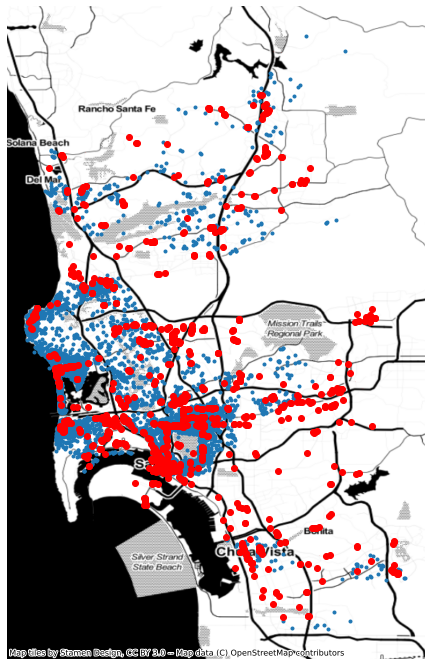

In [10]:
# Set up figure and axis
f,ax = plt.subplots(1,figsize=(12, 12))
# Plot AirBnb properties
airbnbs.plot(ax=ax, marker='.')
# Plot POIs in red
pois.plot(ax=ax, color='r')
# Add Stamen's Toner basemap
contextily.add_basemap(
    ax, 
    crs=airbnbs.crs.to_string(), 
    source=contextily.providers.Stamen.Toner
)
# Remove axes
ax.set_axis_off()
# Display
plt.show()

Now, for some feature engineering. It may be extremely useful to know whether an AirBnB is located in a "hot" location, with a lot of restaurants and bars to choose from. Alternatively, if AirBnBs are very remote, they might not be as lucrative for short, expensive "city-break" reservations. That is, AirBnB users may decide to reserve stays where there are a lot of dining and drinking opportunities, and thus may be *willing to pay more* for the same accommodation. We might be able to predict prices better if we know about the drinking and dining scene near the AirBnB. 

Thus, we can *engineer features* in the AirBnB data using the nearby POIs. To do this, we can create a new feature for the AirBnB dataset --that is, a new column in `airbnbs`-- which incorporates information about how many POIs are *nearby* each property. This kind of "feature counting" is useful in applications where the mere presence of nearby features can affect the quantity we are modeling. 

To do this kind of feature engineering, let us first walk through what we need to do at a conceptual level: 

1. Decide what is *nearby*. This will dictate how far we go from each AirBnB when counting the number of "nearby" bars & restaurants. For this example, we will use 500 meter buffer, which is approximately the distance of a leisurely ten-minute walk.
2. For each AirBnB, determine whether POIs are *within* a leisurely ten-minute walk. 
3. Count how many POIs are within the specified radius of each AirBnB.

At the end of this procedure, we have the number of bars & restaurants that are within a leisurely walk of the AirBnB, which might be useful in predicting the price of each AirBnB. 

Let us now translate the list above into code. For part 1., we need to be able to measure distances in meters. However, `airbnbs` is originally expressed in degrees, since it is provided in terms of locations in latitude and longitude:

In [11]:
airbnbs.crs

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In addition, the `pois` are also provided in terms of their latitude & longitude:

In [12]:
pois.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Therefore, we need to convert this into a coordinate system that is easier to work with. Here, we will use a projection common for mapping in California, the California Albers projection:

In [13]:
airbnbs_albers = airbnbs.to_crs(epsg=3311)
pois_albers = pois.to_crs(epsg=3311)

In [14]:
pois_albers.crs

<Projected CRS: EPSG:3311>
Name: NAD83(HARN) / California Albers
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: United States (USA) - California.
- bounds: (-124.45, 32.53, -114.12, 42.01)
Coordinate Operation:
- name: California Albers
- method: Albers Equal Area
Datum: NAD83 (High Accuracy Reference Network)
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

With this, we can create the radius of 500m around each AirBnB. This is often called *buffering*, where a shape is dilated by a given radius.

In [15]:
airbnbs_albers['buffer_500m'] = airbnbs_albers.buffer(500)

Now, `abb_buffer` contains a 500-meter circle around each AirBnB.

Using these, we can count the number of POIs that are within these areas using a *spatial join*. Spatial joins link geometries based on spatial relationships (or predicates). Here, we need to know the relationship: `pois within airbnb_buffers`, where `within` is the predicate relating `pois` to `airbnb_buffers`. Predicates are not always *reversible*: no `airbnb_buffer` can be `within` a `poi`. In `geopandas`, we can compute all pairs of relations between the `pois` and `airbnb_buffers` efficiently using the `sjoin` function, which takes a `predicate` argument defining the requested relationship between the first and second argument. 

In [16]:
# Spatial join, appending attributes from right table to left one
joined = geopandas.sjoin(
    # Right table - POIs
    pois_albers,
    # Left table - Airbnb with the geometry reset from the original
    # points to the 500m buffer and selecting only `id` and
    # `buffer_500m` column
    airbnbs_albers.set_geometry('buffer_500m')[['id', 'buffer_500m']],
    # Operation (spatial predicate) to use for the spatial join (`within`)
    op="within"
)

The resulting `joined` object contains a row for every pair of POI and AirBnB that are linked. From there, we can apply a group-by operation, using the AirBnB ID, and count how many POIs each AirBnB has within 500m of distance:

In [17]:
# Group POIs by Airbnb ID (`id`)
poi_count = joined.groupby(
    "id"
# Keep only POI id column (`osmid`)
)[
    "osmid"
# Count POIs by Airbnb + convert Series into DataFrame
].count().to_frame(
    'poi_count'
)
# Print top of the table
poi_count.head()

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,poi_count
id,
6,12
5570,7
9553,12
38245,1
69385,8


The resulting `Series` is indexed on the AirBnB IDs, so we can assign it to the original `airbnbs` table. In this case, we know by construction that missing AirBnBs in `poi_count` do not have any POI within 500m, so we can fill missing values in the column with zeros.

In [18]:
airbnbs_w_counts = airbnbs_albers.merge(
    poi_count, left_on='id', right_index=True
).fillna({"poi_count": 0})

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


We can visualize now the distribution of counts to get a sense of how "well-served" AirBnB properties are arranged over space:

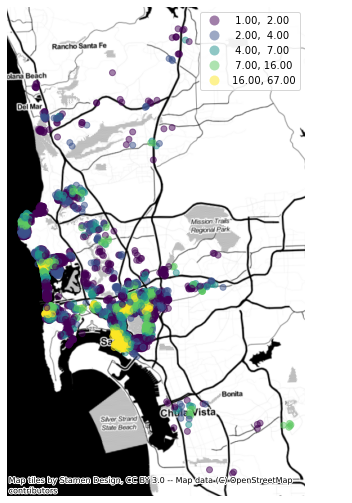

In [19]:
# Set up figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot quantile map of No. of POIs for every Airbnb
airbnbs_w_counts.plot(
    column="poi_count",
    scheme="quantiles",
    alpha=0.5,
    legend=True,
    ax=ax
)
# Add basemap
contextily.add_basemap(
    ax, 
    crs=airbnbs_albers.crs.to_string(), 
    source=contextily.providers.Stamen.Toner
)
# Remove axes
ax.set_axis_off();

### Assigning point values from surfaces: elevation of AirBnBs

We have just seen how to count points around each observation in a point dataset. In other cases, we might be confronted with a related but different challenge: transferring the value of a particular point in a surface to a point in a different dataset. 

To make this more accessible, let us illustrate the context with an example question: *what is the elevation of each AirBnB property?* To answer this question, we require, at least, the following:

1. A sample of AirBnB property locations.
1. A dataset of elevation. We will use here the [NASA DEM](../data/nasadem/README.md) surface for the San Diego area.

Let  us open and plot the file with elevation data:

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


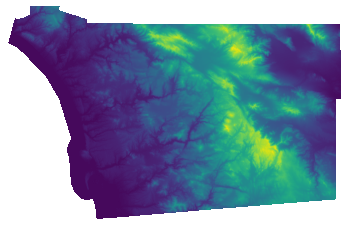

In [20]:
# Open file
dem = rasterio.open("../data/nasadem/nasadem_sd.tif")
# Set up figure and axis
f, ax = plt.subplots()
# Display elevation data on created axis
rioshow(dem, ax=ax)
# Remove axes
ax.set_axis_off();

Let's first check the CRS is aligned with our sample of point locations:

In [21]:
dem.crs

CRS.from_epsg(4326)

We have opened the file with `rasterio`, which has not read the entire dataset just yet. This feature allows us to use this approach with files that are potentially very large, as only requested data is read into memory. To extract a discrete set of values from the elevation surface in `dem`, we can use `sample`. For a single location, this is how it works:

In [22]:
list(dem.sample([(-117.24592208862305, 32.761619109301606)]))

[array([7], dtype=int16)]

Now, we can  apply this logic to a sequence of coordinates. For that, we need to extract them from the `geometry` object:

In [23]:
# Create table with XY coordinates of Airbnb locations
abb_xys = pandas.DataFrame(
    {"X": airbnbs.geometry.x, "Y": airbnbs.geometry.y}
# Convert from DataFrame to array of XY pairs
).to_records(index=False)

And then we can apply the same logic as above to sample elevation for the list of Airbnb locations:

In [24]:
# Save results as a DataFrame
elevation = pandas.DataFrame(
    # Sequence of elevation measurements sampled at the Airbnb locations
    dem.sample(abb_xys),
    # Name of the column to be created to store elevation
    columns=["Elevation"],
    # Row index, mirroring that of Airbnb locations
    index=airbnbs.index
)
# Print top of the table
elevation.head()

,Elevation
0,112
1,3
2,99
3,114
4,30


Now we have a table with the elevation of each  AirBnB property, we can plot the site elevations on a map for visual inspection:

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


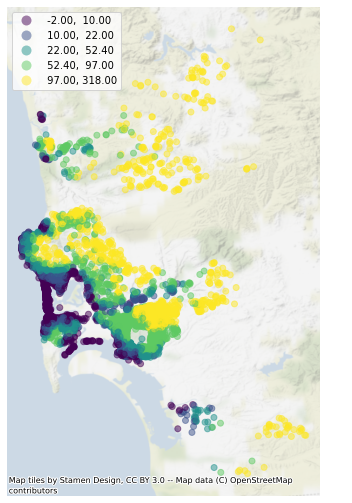

In [25]:
# Set up figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))
# Join elevation data to original Airbnb table
airbnbs.join(
    elevation
# Plot elevation at each Airbnb location as a quantile choropleth
).plot(
    column="Elevation",
    scheme="quantiles",
    legend=True,
    alpha=0.5,
    ax=ax
)
# Add Stamen's terrain basemap
contextily.add_basemap(
    ax, 
    crs=airbnbs.crs.to_string(), 
    source=contextily.providers.Stamen.TerrainBackground,
    alpha=0.5
)
# Remove axes
ax.set_axis_off();

### Point Interpolation using scikit-learn 

In the previous example, we have transferred information from a surface (stored in a raster layer) to a set of points; in other words, we have gone from surface to points. Sometimes, however, we do not have the luxury of a ready-made surface. Instead, all we have available is a set of points with measurements for the variable of interest that do not match the points we want the information for. In this situation, a solution we can rely on is *spatial interpolation*. For a continuous geographical field measured at a set of points, *spatial interpolation* methods provide us a way to guess at the value a field would take at sites we do not measure. 

There are many sophisticated methods with which this can be done. *Kriging*, common in the sub-field of spatial statistics called "geostatistics," is one such practice based on the theory of *Gaussian Process Regression.* Another common approach, *geographically-weighted regression*, provides unique model estimates at every control point, as well as predictions for places where there is no data. Here, though, we'll use a fairly basic $k$-nearest neighbor prediction algorithm from `scikit-learn` to demonstrate the process. 

In [26]:
from sklearn.neighbors import KNeighborsRegressor

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


This algorithm will select the nearest ten listings, then compute the prediction using a weighted average of these nearest observations. To keep predictions relatively consistent, we will build an interpolation only for listings that are entire homes/apartments with two bedrooms:

In [27]:
two_bed_homes = airbnbs[
    airbnbs['bedrooms']==2 & airbnbs['rt_Entire_home/apt']
]

Once subset, we can extract the XY coordinates for each of them into a 2D array:

In [28]:
two_bed_home_locations = numpy.column_stack(
    (two_bed_homes.geometry.x, two_bed_homes.geometry.y)
)

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


To plot the interpolated surface, we must also construct a grid of locations for which we will make predictions. This can be done using `numpy.meshgrid`, which constructs all the combinations of the input dimensions as a grid of outputs. 

In [29]:
# Extract bounding box of Airbnb locations
xmin, ymin, xmax, ymax = airbnbs.total_bounds
# Generate X and Y meshes for the space within the bounding box
x, y = numpy.meshgrid(
    numpy.linspace(xmin, xmax), numpy.linspace(ymin,ymax)
)

To build an intuition on what they are, we can visualise both meshes side by side:

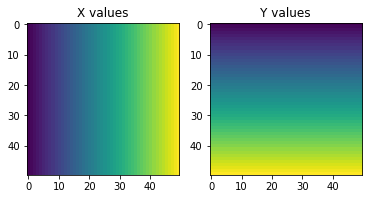

In [30]:
# Set up figure
f,ax = plt.subplots(1,2)
# Plot X mesh
ax[0].imshow(x)
# Plot Y mesh
ax[1].imshow(y)
# Label X mesh
ax[0].set_title('X values')
# Label Y mesh
ax[1].set_title('Y values')
# Display
plt.show()

With these coordinates, we can make a GeoDataFrame containing the grid cells at which we would like to predict:

In [31]:
# Bind a 1D (flattened) of X and Y meshes into a 2D array
grid = numpy.column_stack((x.flatten(), y.flatten()))
# Convert a 1D (flattened) version of X and Y meshes into a geo-table
grid_df = geopandas.GeoDataFrame(
    geometry=geopandas.points_from_xy(
        x=x.flatten(), y=y.flatten())
)

We can visualise this grid together with the original Airbnb locations to get a better sense of what we have just built:

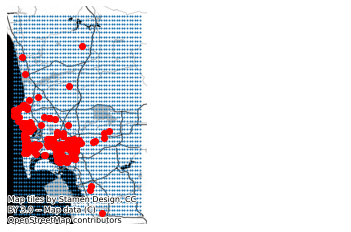

In [32]:
# Plot guid points with size 1
ax = grid_df.plot(markersize=1)
# Plot on top Airbnb locations in red
two_bed_homes.plot(ax=ax, color='red')
# Add basemap
contextily.add_basemap(
    ax, 
    crs=two_bed_homes.crs.to_string(), 
    source=contextily.providers.Stamen.TonerBackground
)
# Remove axes
ax.set_axis_off();

With this done, we can now construct the predictions. First we train the model:

In [33]:
model = KNeighborsRegressor(
    n_neighbors=10, weights='distance'
).fit(two_bed_home_locations, two_bed_homes.price)

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


And then we predict at the grid cell locations:

In [34]:
predictions = model.predict(grid)

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


The result can be displayed as a continuous choropleth, for example:

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


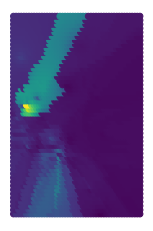

In [35]:
ax = grid_df.plot(predictions)
ax.set_axis_off();

The map is a result not only of the underlying data but also the algorithm we have used. For example, you can see that the surface gets smoother as you increase the number of nearest neighbors to consider:

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


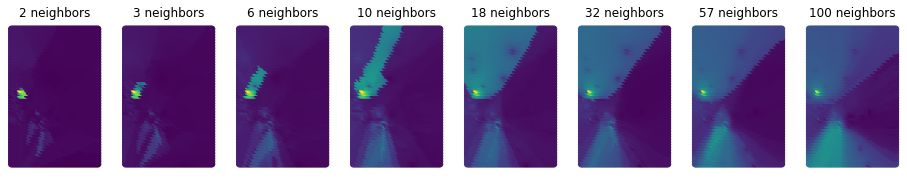

In [36]:
# Set up figure and 8 axes
f,ax = plt.subplots(1,8, figsize=(16,4))
# Loop over eight values equally spaced between 2 and 100
for i,k_neighbors in enumerate(numpy.geomspace(2, 100, 8).astype(int)):
    # Select axis to plot estimates for that value of k
    facet = ax[i]
    # Set up a KNN regressor instance with k_neighbors neighbors
    predictions = KNeighborsRegressor(
        n_neighbors=k_neighbors, weights='distance'
    # Fit instance to the 2-bed subset
    ).fit(
        two_bed_home_locations, two_bed_homes.price
    # Get predictions for locations on the grid
    ).predict(grid)
    # Plot predictions
    grid_df.plot(predictions, ax=facet)
    # Remove axis
    facet.axis('off')
    # Set axis title
    facet.set_title(f"{k_neighbors} neighbors")

Focusing in on central San Diego tells the story a bit more clearly, since there are interesting points there to show. The increasing number of nearest neighbors increases the smoothness of the interpolated surface. To visualise a zoom into the region, we begin by extracting its bounding box:

In [37]:
central_sd_bounds = [-117.179832, 32.655563, -117.020874, 32.769909]
(
    central_xmin, central_ymin, central_xmax, central_ymax
) = central_sd_bounds

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


And repeating the process above for this area, including building the meshes of coordinates:

In [38]:
# Build X and Y meshes
central_x, central_y = numpy.meshgrid(
    numpy.linspace(central_xmin, central_xmax), 
    numpy.linspace(central_ymin, central_ymax)
)
# Bind X and Y meshes in a 2D array
central_grid = numpy.column_stack(
    (central_x.flatten(), central_y.flatten())
)
# Bind X and Y meshes in a geo-table
central_grid_df = geopandas.GeoDataFrame(
    geometry=geopandas.points_from_xy(
        x=central_x.flatten(), y=central_y.flatten()
    )
)

Finally we can reproduce the sequence of figures with different values of K only for the central part of the San Diego area:

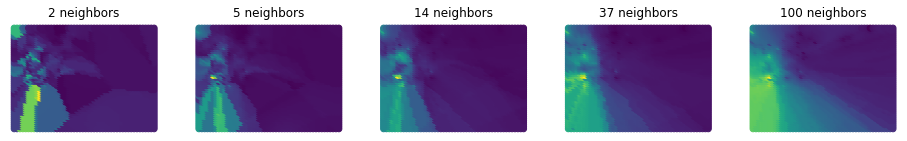

In [39]:
# Set up figure and subplot
f, ax = plt.subplots(1,5, figsize=(16,4), sharex=True, sharey=True)
# Loop over five values equally spaced between 2 and 100
for i,k_neighbors in enumerate(numpy.geomspace(2, 100, 5).astype(int)):
    # Select axis to plot estimates for that value of k
    facet = ax[i]
    # Set up a KNN regressor instance with k_neighbors neighbors
    predictions = KNeighborsRegressor(
        n_neighbors=k_neighbors, weights='distance'
    # Fit instance to the 2-bed subset
    ).fit(
        two_bed_home_locations, two_bed_homes.price
    # Get predictions for locations on the grid
    ).predict(central_grid)
    # Plot predictions
    central_grid_df.plot(predictions, ax=facet)
    # Remove axis
    facet.axis('off')
    # Set axis title
    facet.set_title(f"{k_neighbors} neighbors")

Plenty more of these methods are implemented in `scikit-learn.neighbors`, as well as kriging methods in `GSTools` {cite}`sebastian_muller_2021_5169658` and geographically-weighted regression in `mgwr` {cite}`oshan2019mgwr}. 

### Polygon to point

We now move on to a case where the information we are interested in matching to our set of points is stored in a polygon geography. For example, we would like to know the population density of the neighborhood in which each AirBnB is located. This is conceptually similar to the sampling example above, but in the case the information we want to sample is not a surface but a geo-table of polygons. To determine density, we will download population estimates at the Census tract level, and "transfer" those estimates over to each AirBnB point. Geographically, the only challenge here is finding the containing polygon for each point, and then performing what is in spatial databases parlance known as a "spatial join", by which we link the two layers through their spatial connection.

Let us pull down the number of inhabitants from the American Community Survey for tracts in San Diego:

In [40]:
%%time
acs = cenpy.products.ACS()
sd_pop = acs.from_msa(
    "San Diego, CA",
    level = "tract",
    variables=['B02001_001E']
)

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/opt/conda/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


CPU times: user 2.77 s, sys: 236 ms, total: 3.01 s
Wall time: 42.2 s


In [41]:
try:
    _ = geopandas.read_file("../data/cache/sd_census.gpkg")
except:
    sd_pop.to_file("../data/cache/sd_census.gpkg", driver="GPKG")

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/opt/conda/lib/python3.8/site-packages/geopandas/geodataframe.py:577: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


The code snippet above sends a query to the Census Bureau server to fetch the data for San Diego. Note that it _requires_ internet connectivity to work. If you are working on the book _without_ connectivity, a cached version of the dataset is available on the data folder and can be read as:

In [42]:
sd_pop = geopandas.read_file("../data/cache/sd_census.gpkg")

And calculate population density:

In [43]:
sd_pop["density"] = sd_pop["B02001_001E"] / sd_pop.to_crs(epsg=3311).area

Now, to "transfer" density estimates to each AirBnB, we can rely on the spatial join in `geopandas`:

In [44]:
j = geopandas.sjoin(airbnbs, sd_pop.to_crs(airbnbs.crs))

The result is a table with one row per AirBnB and one column for each attribute we originally had for properties, *as well as* those of the tract where the area is located:

In [45]:
j.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 6110 entries, 0 to 6068
Data columns (total 28 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   accommodates        6110 non-null   int64   
 1   bathrooms           6110 non-null   float64 
 2   bedrooms            6110 non-null   float64 
 3   beds                6110 non-null   float64 
 4   neighborhood        6110 non-null   object  
 5   pool                6110 non-null   int64   
 6   d2balboa            6110 non-null   float64 
 7   coastal             6110 non-null   int64   
 8   price               6110 non-null   float64 
 9   log_price           6110 non-null   float64 
 10  id                  6110 non-null   int64   
 11  pg_Apartment        6110 non-null   int64   
 12  pg_Condominium      6110 non-null   int64   
 13  pg_House            6110 non-null   int64   
 14  pg_Other            6110 non-null   int64   
 15  pg_Townhouse        6110 non-n

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Area to area interpolation

The final case of map matching we consider is transfer of information from one polygon/areal geography to a different one. This is a common use-case when an analysis requires data that is provided at different levels of aggregation and different boundary delineations.

There is a large literature around this problem under the umbrella of dasymetric mapping {cite}`eicher2001dasymetric`. The conceptual idea is relatively straight-forward: we want to apportion values from one set of polygons to another based on how much "geography" is shared. In its simplest case, we can do this based on area. We will assign values from the former geography to the latter one based on how much they share. Let us illustrate this with an example. We will call the geography for which we have data the "source", and that to which we want to transfer data the "target". Let's say we have a population count  measure for each of three source polygons, 1, 2, 3, and we have a target polygon A for which we require an estimated population. If the intersection of polygon A with each of the source polygons amounts to  50%, 30%, and 20% of the total area of polygon A respectively, then the population estimate for A will be a weighted average between the rates in 1, 2, and 3, where the weights are 0.5, 0.3, and 0.2, respectively. 

We could also go in the other direction. If we had total population for polygon A, but population was not reported for polygons 1, 2, 3, we could use areal interpolation to allocate the population from A (now the source polygon) to each of the three target polygons. Polygon 1 would get 0.5 of the population of A, polygon 2 would get 0.3 of A's population, and C the remainder. Here we are assuming the area of A is completely exhausted by the areas of 1, 2, and 3, and that the latter polygons do not overlap with each other. Of course, underlying this exercise is the implicit assumption that the values we are interested in are uniformly distributed within each polygon in the source and target. In some cases, this is a valid assumption or, at least, it does not introduce critical errors; in others, this is not acceptable. Dasymetric mapping has proposed a large amount of sophistications that try to come up with more realistic estimates and that can incorporate additional information.

To implement dasymetric mapping in Python, the best option is `tobler`, a package from the PySAL federation designed exactly for this goal. We will show here the simplest case, that of areal interpolation where apportioning is estimated based on area, but the package also provides more sophisticated approaches.

In [46]:
from tobler.area_weighted import area_interpolate

/opt/conda/lib/python3.8/site-packages/rasterstats/io.py:24: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.9 it will stop working
  from collections import Iterable, Mapping


For the example, we need two polygon layers. We will stick with San Diego and use the set of Census Tracts read above, and a grid layer built using the H3 hexagonal spatial index {cite}`brodsky2018h3`. Our goal will be to create population estimates for each hexagonal cell.

First, let us load the H3 grid:

In [47]:
h3 = geopandas.read_file("../data/h3_grid/sd_h3_grid.gpkg")

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/opt/conda/lib/python3.8/site-packages/geopandas/geodataframe.py:577: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


We are ready to interpolate:

In [48]:
# Area interpolation from polygon geotable to polygon geo-table
interpolated = area_interpolate(
    # Source geo-table (converted to EPSG:3311 CRS)
    source_df=sd_pop.to_crs(epsg=3311),
    # Target geo-table (converted to EPSG:3311 CRS)
    target_df=h3.to_crs(epsg=3311),
    # Extensive variables in `source_df` to be interpolated (e.g. population)
    extensive_variables=["B02001_001E"],
    # Intensive variables in `source_df` to be interpolated (e.g. density)
    intensive_variables=["density"]
)

There is quite a bit going on in the cell above, let us unpack it:

- Remember this method apportions data values based on area, so it makes sense to have an accurate estimate for the extent of each polygon. To do that, we convert each geography to Albers Equal (`EPSG:3311`), which is expressed in meters, using `to_crs`.
- The method `area_interpolate` then takes the source and the target `GeoDataFrame` objects using the same naming convention we have in our explanation. 
- In addition, we need to specify which variables we would like to interpolate. here, Tobler makes a distinction:
    - *Extensive* variables, or absolute values such as counts, aggregates, etc. (which we use for population, `B02001_001E`)
    - *Intensive* variables, such as rates, ratios, etc. (which we select for density as it is the ratio of population over area)

The `interpolated` output object is a geo-table that contains the target polygons and estimates of the variable(s) we originally had for the source geography (population and density in this case). We can illustrate the transfer of information from one geography to the other with the following figure for total population estimates:

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


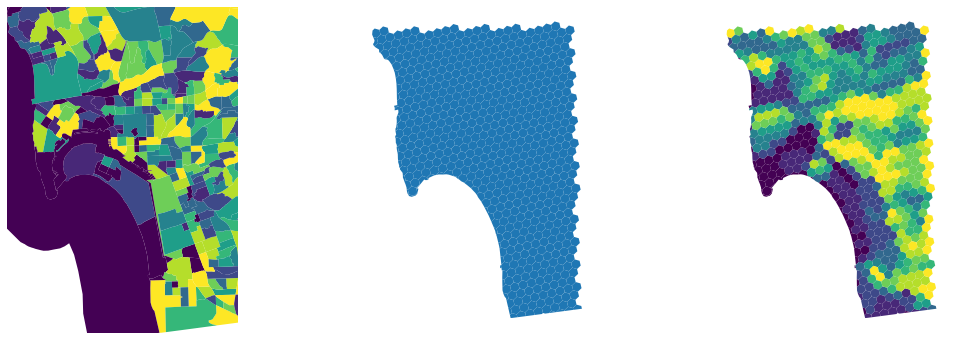

In [49]:
# Set up figure and axes
f, axs = plt.subplots(1, 3, figsize=(18, 6))

# Extract bounding box from output for easier visual comparison
minX, minY, maxX, maxY = interpolated.total_bounds
# Reproject tracts to EPSG:331
sd_pop.to_crs(
    epsg=3311
# Clip to the bounding box
).cx[
    minX:maxX, minY:maxY
# Quantile choropleth for tract population
].plot(
    column="B02001_001E", 
    scheme="quantiles", 
    k=10,
    ax=axs[0]
)
# Remove axes
axs[0].set_axis_off()

# Reproject H3 hexagons to ESPG:3311
h3.to_crs(
    epsg=3311
# Plot hexagons
).plot(
    ax=axs[1], markersize=0.5
)
# Remove axes
axs[1].set_axis_off()

# Plot hexagons with interpolated population
interpolated.plot(
    column="B02001_001E",
    scheme="quantiles",
    k=10,
    ax=axs[2]
)
# Remove axes
axs[2].set_axis_off()

# Adjust limits of tract map to hexagons bounding box
# for easier visual comparison
axs[0].set_xlim(minX, maxX)
axs[0].set_ylim(minY, maxY)
# Display
plt.show()

And similarly for population density:

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


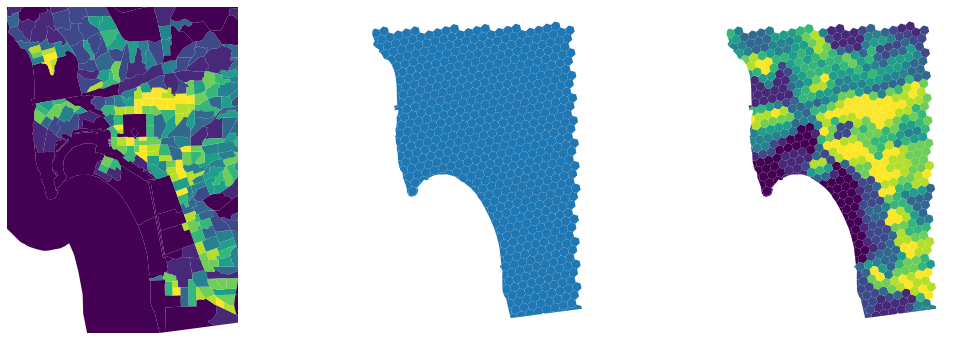

In [50]:
# Set up figure and axes
f, axs = plt.subplots(1, 3, figsize=(18, 6))

# Extract bounding box from output for easier visual comparison
minX, minY, maxX, maxY = interpolated.total_bounds
# Reproject tracts to EPSG:331
sd_pop.to_crs(
    epsg=3311
# Clip to the bounding box
).cx[
    minX:maxX, minY:maxY
# Quantile choropleth for tract population density
].plot(
    column="density", 
    scheme="quantiles", 
    k=10,
    ax=axs[0]
)
# Remove axes
axs[0].set_axis_off()

# Reproject H3 hexagons to ESPG:3311
h3.to_crs(
    epsg=3311
# Plot hexagons
).plot(
    ax=axs[1], markersize=0.5
)
# Remove axes
axs[1].set_axis_off()

# Plot hexagons with interpolated population density
interpolated.plot(
    column="density",
    scheme="quantiles",
    k=10,
    ax=axs[2]
)
# Remove axes
axs[2].set_axis_off()

# Adjust limits of tract map to hexagons bounding box
# for easier visual comparison
axs[0].set_xlim(minX, maxX)
axs[0].set_ylim(minY, maxY)
# Display
plt.show()

## Feature Engineering using Map Synthesis

Feature engineering with map matching is most helpful when you have additional information to use in the analysis. And, with the wealth of freely available data from censuses, satellites, and open volunteered geographic information vendors such as OpenStreetMap, map matching can be a very powerful tool for enriching and improving your analyses. However, it is sometimes *also* useful to only examine the data you've got, and use the spatial structure within to build better features or better models. While this might be done using spatially-explicit models (like those covered in [Chapter 11](11_regression), it is also possible to use map synthesis to build spatial features and improve model performance.

There is an extensive amount of map synthesis features. In fact, many of them are usually derived for specific use cases and following the intuition of domain experts that can take technical guidance along the lines presented here. We discuss two main ones as an illustration, but reiterate the sky really is the limit in this category. First, we will return to spatial *summary* features. Second, we will examine *regionalization features*, which detect and leverage geographical clusters in the data to improve prediction. 

### Spatial Summary Features in Map Synthesis

Just like in map matching, you can use spatial summary features in map synthesis to make create better models. One approach involves constructing spatial summary measures of your training data. This is done in the same manner as in map matching, except we now refer only to the data on hand. Thus, we may want to determine whether nearby AirBnBs are "competing" with each AirBnB. We might do this by finding the distance to the nearest AirBnB with the same number of bedrooms, since two nearby listings that *also* sleep the same number of people likely will compete with one another for tenants. 

#### Counting neighbors

A useful metric to characterise an observation in your data through geography is whether it is surrounded by other observations or not. This question (and the following one we cover) is another area of geographic data science where spatial weights matrices are useful.

If we define to be "surrounded by other observations" as in "having many neighbors", this translates into the cardinalities of a spatial weights matrix (ie. the number of neighbors recorded in the matrix for each observation).

For example, we can "engineer a feature" that contains the number of Airbnb properties each property has within 500 metres by constructing a distance band object:

In [51]:
# Build distance band spatial weights matrix
d500_w = weights.DistanceBand.from_dataframe(
    airbnbs_albers, threshold=500, silence_warnings=True
)

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


And extracting its cardinalities:

In [52]:
card = pandas.Series(d500_w.cardinalities)

The `card` feature we have built will pick up areas of higher concentration of Airbnb properties with higher values, as we can see in the map below.

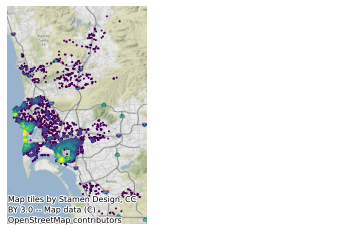

In [53]:
# Set up figure and axis
f, ax = plt.subplots(1)
# Append cardinalities to main Airbnb geo-table
airbnbs.assign(
    card=card
# Plot cardinality quantile choropleth
).plot('card', scheme='quantiles', k=7, markersize=1, ax=ax)
# Add basemap
contextily.add_basemap(ax, crs=airbnbs.crs)
# Remove axes
ax.set_axis_off();

#### Distance buffers within a single table

If what we are interested in is finding the average number of bedrooms around each house, we might do this with using a row-standardised version of the `DistanceBand` weight object we have just built, which considers AirBnB as "neighbors" if they are within the distance threshold, and computing the spatial lag of the number of bedrooms.

In [54]:
# Row standardise
d500_w.transform = 'r'
# Compute spatial lag of No. of bedrooms
local_average_bedrooms = weights.lag_spatial(
    d500_w, airbnbs_albers[['bedrooms']].values
)

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


While related, these features contain quite distinct pieces of information, and both may prove useful in modeling: 

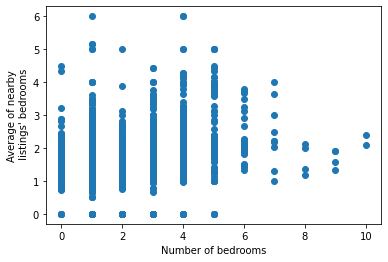

In [55]:
plt.scatter(airbnbs_albers[['bedrooms']].values, local_average_bedrooms)
plt.xlabel("Number of bedrooms")
plt.ylabel("Average of nearby\n listings' bedrooms");

If we were instead interested in the most common number of bedrooms, rather than the average, we could use the `lag_categorical` function, which will consider each value as a category and return the most common value in each neighbor set:

In [56]:
local_mode = weights.lag_categorical(
    d500_w, airbnbs_albers[['bedrooms']].values
)

/opt/conda/lib/python3.8/site-packages/libpysal/weights/spatial_lag.py:167: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  normalized_labels = np.zeros(y.shape, dtype=np.int)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Since we are now treating the number of bedrooms as a discrete feature, we can use a `crosstab` from `pandas` to examine the relationship between a listing and the typical size of listings nearby:

In [57]:
crosstab = pandas.crosstab(
    airbnbs_albers.bedrooms, local_mode.flatten()
)
crosstab.columns.name = "nearby"
crosstab

nearby,0.0,1.0,2.0,3.0,4.0,5.0,6.0
bedrooms,,,,,,,
0.0,5,391,39,8,1,0,1
1.0,2,3068,215,32,17,4,0
2.0,1,977,268,13,3,1,0
3.0,3,427,164,37,11,2,0
4.0,0,168,55,11,31,5,3
5.0,0,53,16,3,8,18,0
6.0,0,13,9,2,3,2,0
7.0,0,5,1,2,1,1,0
8.0,0,3,1,0,0,0,0


From the table we can see the most common case (N=3067) is properties with one bedroom surrounded mostly by other properties with also only one bedroom. Similarly we also find out, for example, that the two properties with ten bedrooms in the dataset are surrounded by properties with mostly two bedrooms. The remaining cells in the table can be interpreted in a similar fashion.

If more complicated statistics are required, it can help to re-express the construction of summary statistics as a *reduction* of the *adjacency list* representation of our weights, as done in [Chapter 3](03_spatial_data). To recap, the *adjacency list* is a `pandas.DataFrame` where each row contains a single link in our graph. It contains the identifier for some `focal` observation, the identifier for some `neighbor` observation, and a value for the `weight` of the link that connects the `focal` and `neighbor`:

In [58]:
adjlist = d500_w.to_adjlist()

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [59]:
adjlist.head()

,focal,neighbor,weight
0,0,136,0.023256
1,0,279,0.023256
2,0,317,0.023256
3,0,616,0.023256
4,0,761,0.023256


If we had the values for each for the neighbors in this adjacency list table, then we could use a `groupby()` to summarize the values of observations connected to a given focal observation. This merge can be done directly with the original data, linking the `neighbor` key in the adjacency list back to that observation in our source table: 

In [60]:
adjlist = adjlist.merge(
    airbnbs_albers[['bedrooms']], 
    left_on='neighbor', 
    right_index=True, 
    how='left'
)
adjlist.head()

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,focal,neighbor,weight,bedrooms
0,0,136,0.023256,1.0
1,0,279,0.023256,3.0
2,0,317,0.023256,2.0
3,0,616,0.023256,1.0
4,0,761,0.023256,1.0


Now, we need only to group the adjacency list by the focal observation and summarize the `bedrooms` column to obtain the median number of bedrooms for each `focal` observation. 

In [61]:
adjlist.groupby("focal").bedrooms.median()

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


focal
0       1.0
1       2.0
2       1.0
4       1.0
5       1.0
       ... 
6105    1.0
6106    1.0
6107    1.0
6108    1.0
6109    1.0
Name: bedrooms, Length: 6035, dtype: float64

Since the mean and/or mode are the most commonly-used measures of central tendency, the `lag_spatial` and `lag_categorical` functions cover many of the required uses in practice. 

#### "Ring" buffer features

Sometimes, analysts might want to use multiple "bands" of buffer features. This requires that we build summaries of the observations that fall *only within* a given range of distances, such as the typical size of houses that are further than 500m, but still within one kilometer. This kind of "ring buffer", or annulus, is a common request in spatial analysis, and can be done in substantially the same way as before by increasing the `threshold` in a `DistanceBand` weight.  

We can use our 500m weights from before to build the average again:

In [62]:
average_within_500 = weights.lag_spatial(
    d500_w, airbnbs_albers[['bedrooms']].values
)

Then, we need to build the graph of AirBnBs that fall *between* 500m and one kilometer from one another. To start, we build the `DistanceBand` graph of all listings closer than one kilometer:

In [63]:
d1k_w = weights.DistanceBand.from_dataframe(
    airbnbs_albers, threshold=1000, silence_warnings=True
)

Then, using the `weights.set_operations` module, we can express set-theoretic relationships between graphs. Here, we need to *remove* the links in our one kilometer graph that are *also* links in the 500m graph. To do this, we need `w_difference(d1k_w, d500_w)`, the difference between the one kilometer graph and the 500m graph: 

In [64]:
d1k_exclusive = weights.set_operations.w_difference(
    d1k_w, d500_w, constrained=False
)

/opt/conda/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 60 disconnected components.
 There are 32 islands with ids: 762, 907, 976, 1003, 1776, 1867, 2789, 2841, 3130, 3138, 3184, 3604, 3748, 3962, 3989, 4366, 4443, 4627, 4764, 4885, 4989, 5014, 5536, 5733, 5756, 5790, 5796, 5808, 6005, 6026, 6049, 6068.
  warnings.warn(message)


Then, we can compute the average size of listings between 500m and one kilometer in the same manner as before using our `d1k_exclusive` graph, which now omits all edges shorter than 500m. 

In [65]:
d1k_exclusive.transform = 'r'
average_500m_to_1k = weights.lag_spatial(
    d1k_exclusive, airbnbs_albers[['bedrooms']].values
)

('WARNING: ', 762, ' is an island (no neighbors)')
('WARNING: ', 907, ' is an island (no neighbors)')
('WARNING: ', 976, ' is an island (no neighbors)')
('WARNING: ', 1003, ' is an island (no neighbors)')
('WARNING: ', 1776, ' is an island (no neighbors)')
('WARNING: ', 1867, ' is an island (no neighbors)')
('WARNING: ', 2789, ' is an island (no neighbors)')
('WARNING: ', 2841, ' is an island (no neighbors)')
('WARNING: ', 3130, ' is an island (no neighbors)')
('WARNING: ', 3138, ' is an island (no neighbors)')
('WARNING: ', 3184, ' is an island (no neighbors)')
('WARNING: ', 3604, ' is an island (no neighbors)')
('WARNING: ', 3748, ' is an island (no neighbors)')
('WARNING: ', 3962, ' is an island (no neighbors)')
('WARNING: ', 3989, ' is an island (no neighbors)')
('WARNING: ', 4366, ' is an island (no neighbors)')
('WARNING: ', 4443, ' is an island (no neighbors)')
('WARNING: ', 4627, ' is an island (no neighbors)')
('WARNING: ', 4764, ' is an island (no neighbors)')
('WARNING: ', 4

Thus, we can see that the two features definitely contain distinct, but related, information, and both may be valuable as features when attempting to predict features of interest. 

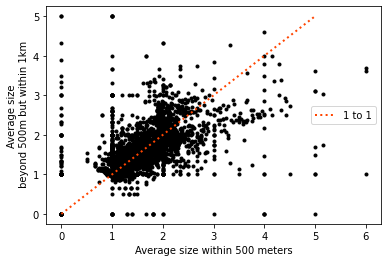

In [66]:
# Plot scatter
plt.scatter(
    average_within_500,
    average_500m_to_1k,
    color='k', marker='.'
)
# Rename horizontal axis
plt.xlabel("Average size within 500 meters")
# Rename vertical axis
plt.ylabel("Average size\n beyond 500m but within 1km")
# Plot line of 45 degrees
plt.plot(
    [0,5],
    [0,5], 
    color='orangered', 
    linestyle=':', 
    linewidth=2, 
    label='1 to 1'
)
# Add legend
plt.legend();

As the plot shows, although the relationship between both is positive, there is quite a bit of variation and departure from the (red) line of equality. These represent cases with either larger (above the line) or smaller (below) average size in the 500m to 1km ring than in the 500m buffer.

### Clustering as feature engineering

One unique way to use spatial or features information *within* your data as a feature in your existing models is to use *clustering*, as we saw in Chapters [8](08_point_pattern_analysis) & [10](10_clustering_and_regionalization), respectively. This can provide an indication of whether an observation exists in a given "place" geographically, or if an observation is a specific "kind" of observation. Data reduction of many variates into a derived categorical feature can be useful in training models. This is even more useful when the *spatial location* of a given observation indicates a useful characteristic about the kind of observation that may be found at that location. 

While sometimes we might prefer to introduce space and (co-)location through our model (as we did in [Chapter 11](11_regression)), others we can instead use (spatial) cluster labels themselves as features. For example, to cluster the listings based on their location, we can use hierarchical DBSCAN {cite}`campello2013density`, an improved variant of the traditional DBSCAN algorithm used in [Chapter 8](08_point_pattern_analysis). We import it through its own package {cite}`mcinnes2017hdbscan`:

In [67]:
from hdbscan import HDBSCAN

To apply to our Airbnb data, we need the coordinates as a 2D array of XY pairs:

In [68]:
coordinates = numpy.column_stack(
    (airbnbs_albers.geometry.x, airbnbs_albers.geometry.y)
)

With a little tuning, we can decide on an effective parameterization. The main advantage of HDBSCAN over the traditional approach is that it reduces the number of tuning parameters from two to one: we only need to set the minimum number of observations we want to define a cluster. Here, we look for relatively large clusters of AirBnBs, those with about 25 listings or more, fit it to our array of coordinates and store the cluster labels identified:

In [69]:
labels = HDBSCAN(min_cluster_size=25).fit(coordinates).labels_

/opt/conda/lib/python3.8/site-packages/hdbscan/hdbscan_.py:275: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  alg = KDTreeBoruvkaAlgorithm(tree, min_samples, metric=metric,
/opt/conda/lib/python3.8/site-packages/hdbscan/hdbscan_.py:56: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://nump

The spatial distribution of these clusters will give us a sense of areas of San Diego with relatively high density of the observations. But the `labels` object does not contains clusters, only observation memberships. To derive those clusters geographically, we construct the convex hull of the observations in each detected cluster, creating thus a polygon that delimits every observation that is part of the cluster:

In [70]:
hulls = airbnbs_albers[['geometry']].dissolve(by=labels).convex_hull

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


The polygons in `hulls` provide an intermediate layer between the granularity of each individual location and the global scale of San Diego as a geographical unit. Since people tend to make locational decisions hierarchically (e.g. first select *San Diego* as a destination, then they pick a particular *part* of San Diego, then choose a house within the area), this approach might give us reasonable insight into enclaves of Airbnb properties:

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


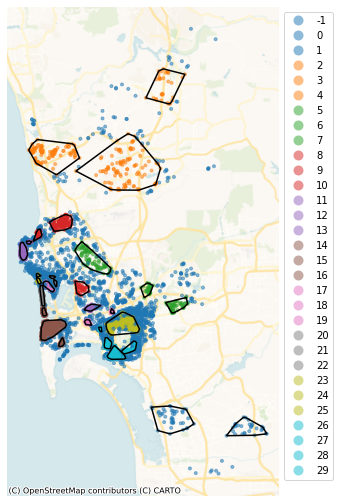

In [71]:
# Set up figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot individual Airbnb locations
airbnbs_albers.plot(
    # Colour by cluster label
    column=labels,
    # Consider label as categorical
    categorical=True,
    # Add 50% of transparency
    alpha=0.5,
    # Include legend
    legend=True,
    # Draw on axis `ax`
    ax=ax, 
    # Use circle as marker
    marker='.',
    # Position legend outside the map
    legend_kwds={'bbox_to_anchor': (1,1)}
)
# Plot convex hull polygons for each cluster label
# except that for -1 (observations classified as noise)
hulls[hulls.index != -1].boundary.plot(color='k', ax=ax)
# Add basemap
contextily.add_basemap(
    ax, 
    crs=airbnbs_albers.crs.to_string(), 
    source=contextily.providers.CartoDB.VoyagerNoLabels
)
# Remove axes
ax.set_axis_off();

Note how the hierarchical nature of HDBSCAN, which picks density thresholds _locally_ is at work in the map, where some of the clusters (e.g. orange ones in the north) display lower density than parts of the center which are _not_ part of any cluster. These results also capture some information about the price of a listing. We can see this if we plot the distribution of prices across the detected clusters:

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


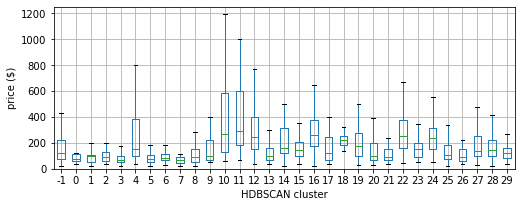

In [72]:
# Set up figure
f = plt.figure(figsize=(8,3))
# Add box plots of price by HDBSCAN cluster
ax = airbnbs_albers.boxplot(
    # Plot distribution of 'price'
    "price", 
    # Group by cluster label, generating one box plot/cluster
    by=labels, 
    # Do not display individual outlier observations
    flierprops=dict(marker=None), 
    # Draw visualisation on the current axis (inside `f`)
    ax=plt.gca()
)
# Set label for horizontal axis
ax.set_xlabel("HDBSCAN cluster")
# Set labels for vertical axis
ax.set_ylabel("price ($)")

# Remove default figure title
plt.gcf().suptitle(None)
# Remove default axis title
ax.set_title(None)
# Re-adjust vertical value range for easier legibility
ax.set_ylim(0,1250);

If we want to capture the variation picked up by membership to these clusters in a regression model, we could use these labels as the basis for spatial fixed effects, for example, as we saw in [Chapter 11](11_regression).

## Conclusion

Feature engineering is a powerful way to enrich your data and make the most out of them. It is often within reach whether you are able to mix in auxilliary data or not. At a minimum, it only requires that new variables are constructed from your existing data; however if you have access to more data, spatial feature engineering provides the *ultimate linkage key*, a flexible and powerful tool with which you can unlock the value held in many *other* datasets that you may have access to even if they are not obviously connected to your own. 

We have structured all the approaches presented in this chapter along two main groups: those which allow you to augment a given dataset, which we have termed _map synthesis_; and those that enable connecting disparate datasets through space. In both cases, each operation involved in feature engineering, such as determining what the average value is in the area near each observation or identifying whether observations exist as part of a "cluster", are relatively simple operations. As building blocks that may be combined with each other, they build large, rich, and useful datasets that can be used directly in your existing methods of analysis. 

Beyond feature engineering, statistical techniques we discuss in this book (particularly in Chapters [10](10_clustering_and_regionalization) and [11](11_regression)) can leverage spatial structure *directly* during learning/inference. These techniques allow you to embed space in non-spatial models to make them "geography aware". Furthermore, the techniques in this chapter (and the methods that extend upon them) are immediately useful for most practicing data scientists, and can be integrated into nearly any analytical method or approach. 

## Questions

1. Thinking of your own research, provide an example where map matching would
   be a useful spatial feature engineering approach? How about an example where
   map synthesis would be useful for your research?
2. In the  **Counting *nearby* features** example early in the chapter, there
   is a potential issue with under-counting the number of nearby bars and
   restaurants for certain AirBnBs in the dataset. Which AirBnBs are subject to
   neighbor under-counts and why?
3. How would you correct the under-count in the previous question?
4. Dasymetric mapping may introduce spurious spatial autocorrelation (see
   Chapters 6 and 7) through
   the interpolation process. How does this occur and why is it important to acknowledge?
5. From the previous spatial regression chapter, is the SLX model a map matching or a map synthesis technique?
6. Feature engineering is can be used in many different applied contexts. When might feature engineering actually *not* improve a model? 

## Next Steps

For more information on machine learning methods, it is difficult to beat *Introduction to Statistical Learning* by James, Witten, Hastie, and Tibshirani: 

James, Gareth, Daniela Witten, Trevor Hastie, and Robert Tibshirani. 2021. *Introduction to Statistical Learning* (2nd Edition). Wiley: New York. 

In addition, there are many geospatial relationships that can be leveraged to merge datasets together. These *spatial join* techniques often require quite a bit of background understanding in *geocomputation*, computation that focuses on the basic/fundamental geometric operations and relationships between geographic objects. However, simple introductions are offered by our partner book, 

Tenkanen, Henrikki, Vuokko Heikinheimo, and David Whipp. 2023. *Python for Geographic Data Analysis*. CRC Press: Boca Raton, FL. https://pythongis.org

Finally, references on geographic interpolation methods are sometimes hard to come by, but a good and readable introduction to the domain is offered by Comber and Zeng:

Comber, Alexis and Wen Zeng. 2019. "Spatial Interpolation using areal features: A review of methods and opportunities using new forms of data with coded illustrations." *Geography Compass* 13.  https://doi.org/10.1111/gec3.12465